## Cats and dogs classification using pretrained ResNet50 

- Dataset information: **OXFORD-IIIT PET Dataset**
- The model in this notebook is trained on **37 category pet dataset(cats and dogs) with roughly 200 images in each class**. The images have large variations in the scale, pose and lighting.

### Import and installation section

In [1]:
!pip install patool

     |████████████████████████████████| 81kB 9.2MB/s 


In [2]:
import os
import glob
import math
import pathlib
import patoolib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import (precision_score, confusion_matrix, recall_score,
                             f1_score, classification_report)

np.random.seed(45)
tf.random.set_seed(123)

### Mount the google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define some global variables

In [4]:
AUTOTUNE = tf.data.AUTOTUNE
# image size for the model
IMG_SIZE = (300, 300)   
BATCH_SIZE = 32
EPOCHS = 12

## Read and prepare data

### Extract images from .rar files 

In [5]:
# path of the .rar data directory
DATA_DIR = '/content/drive/MyDrive/Cats Dogs/cats_dogs.rar'

# data extraction directory
EXTRACT_DIR = '/tmp'

# extract data into EXTRACT_DIR
patoolib.extract_archive(DATA_DIR, outdir = EXTRACT_DIR)

# list the contents of the EXTRACT_DIR
os.listdir(EXTRACT_DIR)

patool: Extracting /content/drive/MyDrive/Cats Dogs/cats_dogs.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/MyDrive/Cats Dogs/cats_dogs.rar"
patool:     with cwd='/tmp'
patool: ... /content/drive/MyDrive/Cats Dogs/cats_dogs.rar extracted to `/tmp'.


['tmpqma29kgg',
 'dap_multiplexer.INFO',
 'drivefs_ipc.0_shell',
 'cats_dogs',
 'initgoogle_syslog_dir.0',
 'debugger_1ekhqqoli9',
 'dap_multiplexer.eb2726c19360.root.log.INFO.20210507-020729.48',
 'drivefs_ipc.0']

In [6]:
# path of the extracted data
data_path = EXTRACT_DIR + '/cats_dogs'
data_path = pathlib.Path(data_path)

# total number of images in the directory
IMAGE_COUNT = len(list(data_path.glob('*.jpg')))
IMAGE_COUNT

7390

### Construct dataframe of image paths and labels

In [7]:
labels = []   # store labels
file_paths = []   # store image file paths

# iterate over the images
for path in tqdm(os.listdir(data_path)):
  # remove .jpg from the file name
  file_name = path.split('.')[0]
  # split file name by underscore to remove image number
  breed_name = file_name.split('_')[:-1]
  # append the breed name to labels
  labels.append('_'.join(breed_name))
  # append image file path
  file_paths.append(os.path.join(data_path, path))

# unique breed names 
CLASS_NAMES = np.unique(labels).tolist()

# construct dataframe from the unique labels
image_df = pd.DataFrame({'file_paths': file_paths, 'classes': labels})

# add column with integer labels
image_df['labels'] = image_df['classes'].apply(lambda x: CLASS_NAMES.index(x))

# print head of the dataframe
image_df.head()

100%|██████████| 7390/7390 [00:00<00:00, 255556.25it/s]


file_paths                 classes  labels
0         /tmp/cats_dogs/english_setter_194.jpg          english_setter      19
1                 /tmp/cats_dogs/Siamese_26.jpg                 Siamese      10
2  /tmp/cats_dogs/english_cocker_spaniel_81.jpg  english_cocker_spaniel      18
3        /tmp/cats_dogs/wheaten_terrier_120.jpg         wheaten_terrier      35
4                  /tmp/cats_dogs/beagle_71.jpg                  beagle      15

### Check the number of images in each class

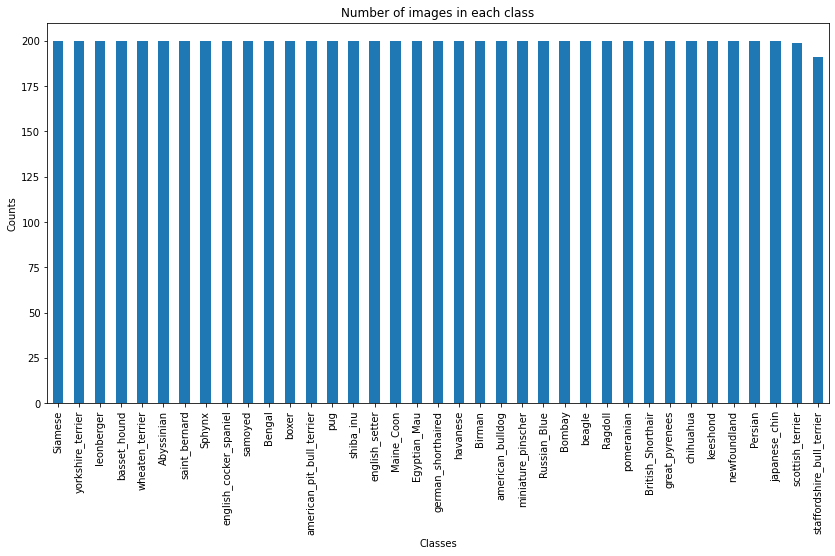

In [8]:
image_df.classes.value_counts().plot(kind = 'bar', figsize = (14, 7), 
                                     xlabel = 'Classes', ylabel = 'Counts',
                                     title = 'Number of images in each class');

- Data is perfectly balanced and contains roughly 200 images in each class

### Construct tf.data.Dataset pipeline

In [9]:
def tf_dataset(image_paths, image_labels):
  """
  This function constructs the tensorflow dataset from image paths and labels
  """
  dataset = tf.data.Dataset.from_tensor_slices((image_paths, image_labels))
  return dataset

# call the above function to get the dataset
dataset = tf_dataset(image_df.file_paths.values, image_df.labels.values)

# print few image paths and labels
for file, label in dataset.take(5):
  print ('Image Path: {}, Label: {}'.format(file, label))

Image Path: b'/tmp/cats_dogs/english_setter_194.jpg', Label: 19
Image Path: b'/tmp/cats_dogs/Siamese_26.jpg', Label: 10
Image Path: b'/tmp/cats_dogs/english_cocker_spaniel_81.jpg', Label: 18
Image Path: b'/tmp/cats_dogs/wheaten_terrier_120.jpg', Label: 35
Image Path: b'/tmp/cats_dogs/beagle_71.jpg', Label: 15


### Partition data into training, validation and test sets

In [10]:
def split_dataset(dataset, test_size = 0.12):
  """
  This function splits the data into training, validation and test sets

  Args:
    dataset: tensorflow dataset object
    test_size: size of the test and validation sets

  Returns:
    training, validation and test sets
  """
  # print the total number of images in the dataset
  NUM_IMAGES = tf.data.experimental.cardinality(dataset).numpy()
  print(f'Total images: {NUM_IMAGES}')

  # shuffle the image files in the combined_ds
  dataset = dataset.shuffle(buffer_size = NUM_IMAGES)

  # split the data into training, validation and test sets
  train_size = (1 - 2 * test_size)
  train_size = int(train_size * NUM_IMAGES)
  test_size = int(test_size * NUM_IMAGES)

  train_ds = dataset.take(train_size)
  remain_ds = dataset.skip(train_size)
  test_ds = remain_ds.take(test_size)
  val_ds = remain_ds.skip(test_size)

  # print the number of images in the training, validation and test datasets
  print(f'Training images: {tf.data.experimental.cardinality(train_ds).numpy()}')
  print(f'Validation images: {tf.data.experimental.cardinality(val_ds).numpy()}')
  print(f'Test images: {tf.data.experimental.cardinality(test_ds).numpy()}')

  return train_ds, val_ds, test_ds

#### Decode image-label pairs

In [11]:
def decode_image(image):
  """
  This function reads and resizes the image
  """
  # convert the compressed string to a 3D uint8 tensor
  image = tf.image.decode_jpeg(image, channels = 3)
  # convert image into tensor object
  image = tf.cast(image, tf.float32) 
  # resize the image to the desired size
  image = tf.image.resize(image, IMG_SIZE)
  return image


def process_path(file_path, label):
  """
  This function constructs the image-label pairs 
  """
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_image(img)
  return img, label

In [12]:
def get_dataset(dataset, batch_size = BATCH_SIZE, repeated = False, cached = False, augment = False):
  """
  This function returns a Tensorflow dataset ready for training or inference

  Args: 
    dataset: tensorflow dataset object 
    batch_size: batch size used for training (default: 32)
    repeated: repeat the dataset for training (default: False)
    cached: cache the dataset for training (default: False)
    augment: perform data augmentation (default: False)

  Returns:
    tensorflow dataset
  """
  # create image-label pair dataset
  # Set `num_parallel_calls` so multiple images are loaded/processed in parallel
  dataset = dataset.map(process_path, num_parallel_calls = AUTOTUNE)

  if augment:
    dataset = dataset.map(data_augment, num_parallel_calls = AUTOTUNE)
    dataset = dataset.map(prepare_image, num_parallel_calls = AUTOTUNE)
  
  if repeated:
    dataset = dataset.repeat()
      
  dataset = dataset.batch(BATCH_SIZE)
  
  if cached:
    dataset = dataset.cache()

  dataset = dataset.prefetch(AUTOTUNE)
  
  return dataset

In [13]:
# split the data into training, validation and test sets
train_ds, val_ds, test_ds = split_dataset(dataset)

train_ds = get_dataset(train_ds)
val_ds = get_dataset(val_ds)
test_ds = get_dataset(test_ds)

Total images: 7390
Training images: 5616
Validation images: 888
Test images: 886


## Display few images from the training set

In [14]:
def display_batch_of_images(databatch, predictions = None):
  """
  This function will work with:
  display_batch_of_images(images)
  display_batch_of_images(images, predictions)
  display_batch_of_images((images, labels))
  display_batch_of_images((images, labels), predictions)
  """
  # separate image label pairs
  try:
    images, labels = databatch
  except:
    images = databatch
    labels = None

  if labels is None:
    labels = [None for _ in enumerate(images)]
      
  # auto-squaring: this will drop data that does not fit into square
  # or square-ish rectangle
  rows = int(math.sqrt(len(images)))
  cols = len(images)//rows
      
  # figure size and spacing
  FIGSIZE = 13.0
  SPACING = 0.1

  subplot = (rows, cols, 1)
  if rows < cols:
    plt.figure(figsize = (FIGSIZE, FIGSIZE/cols*rows))
  else:
    plt.figure(figsize = (FIGSIZE/rows*cols, FIGSIZE))
  
  # display images
  for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
    title = '' if label is None else CLASS_NAMES[label]
    correct = True
    if predictions is not None:
      title, correct = title_from_label_and_target(predictions[i], label)

    # magic formula tested to work from 1x1 to 10x10 images
    dynamic_titlesize = FIGSIZE * SPACING / max(rows, cols) * 40 + 3 
    subplot = display_one_image(image, title, subplot, not correct, titlesize = dynamic_titlesize)
  
  # display layout
  plt.tight_layout()
  if labels is None and predictions is None:
    plt.subplots_adjust(wspace = 0, hspace = 0)
  else:
    plt.subplots_adjust(wspace = SPACING, hspace = SPACING)
  plt.show()

In [15]:
def title_from_label_and_target(label, target):
  if target is None:
    return CLASS_NAMES[label], True
  correct = (label == target)
  return "{} [{}{}{}]".format(CLASS_NAMES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                              CLASS_NAMES[target] if not correct else ''), correct


def display_one_image(image, title, subplot, red = False, titlesize = 16):
  plt.subplot(*subplot)
  plt.axis('off')
  plt.imshow(image.numpy().astype("uint8"))
  if len(title) > 0:
    plt.title(title, 
              fontsize = int(titlesize) if not red else int(titlesize/1.2), 
              color = 'red' if red else 'black', 
              fontdict = {'verticalalignment':'center'}, 
              pad = int(titlesize/1.5))
    
  return (subplot[0], subplot[1], subplot[2] + 1)

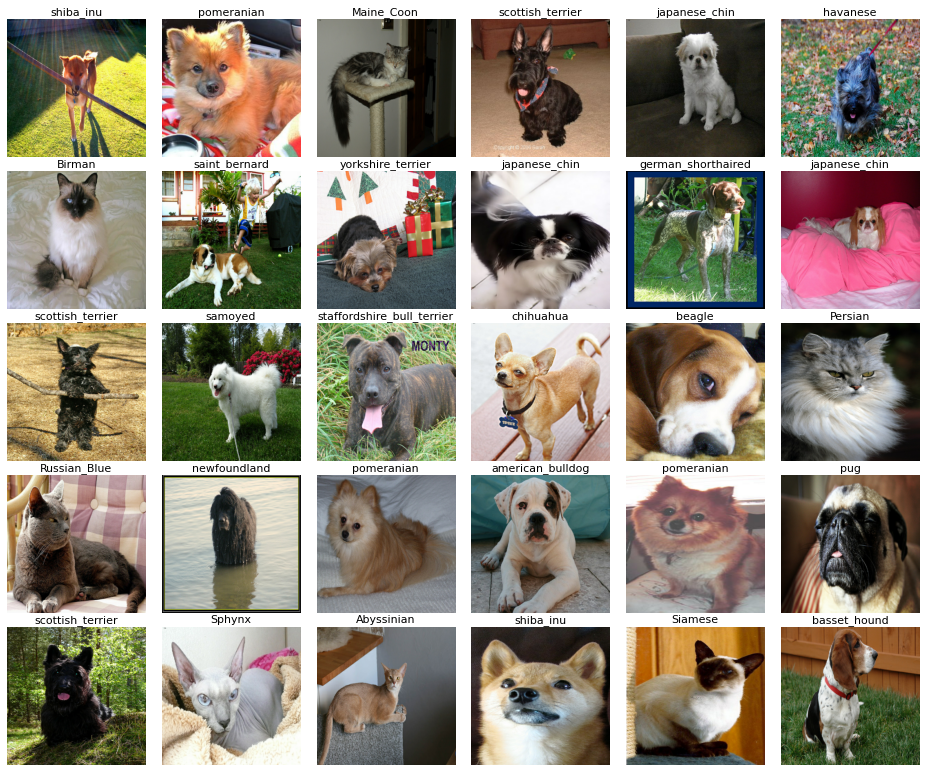

In [16]:
# get the batch of image label pairs from the training dataset
image_batch, label_batch = next(iter(train_ds))

# display the image-label batch
display_batch_of_images((image_batch, label_batch))

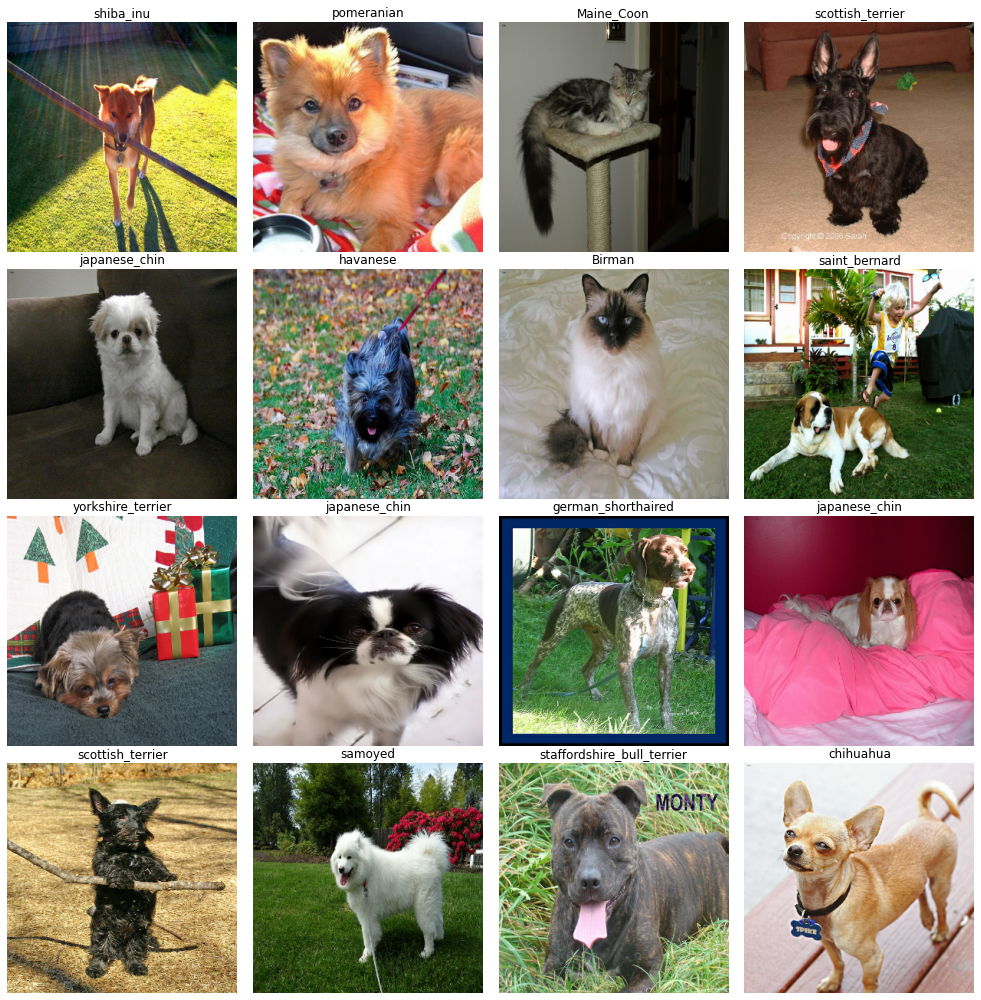

In [17]:
# simple for loop to display few images from the training dataset
fig = plt.figure(figsize = (14, 14))
for i in range(16):
  # fig.add_subplot(4, 4, i + 1)
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(CLASS_NAMES[label])
  plt.axis("off")
plt.tight_layout(w_pad = 0.1, h_pad = 0.1)

## Build and train the model

### Load pre-trained ResNet50 model

In [18]:
def build_model(shape = IMG_SIZE, gpool = True, dropout = 0.0):
  """
  This function loads the pre-trained ResNet50 model

  Args:
    shape (tuple): input shape to the model (default: (300, 300))
    gpool (bool): use GlobalAveragePooling2D layer if True else Flatten layer
    dropout (float): use Dropout layer if dropout > 0

  Returns: 
    keras model instance
  """
  # load the pre-trained ResNet50 model
  base_model = tf.keras.applications.ResNet50(weights = 'imagenet', 
                                              include_top = False, 
                                              input_shape = shape + (3, ))
  
  # freeze all the pre-trained weights of the model
  base_model.trainable = False

  # add a global spatial average pooling layer or flatten layer
  if gpool:
    x = layers.GlobalAveragePooling2D(name = 'gpool')(base_model.output)
  else:
    x = layers.Flatten(name = 'flatten')(base_model.output)

  if dropout > 0:
    x = layers.Dropout(dropout, name = 'dropout')(x)

  # Output layer with 37 classes
  x = layers.Dense(len(CLASS_NAMES), activation = 'softmax', name = 'output')(x)

  # built the final model
  model = tf.keras.Model(base_model.inputs, x, name = 'ResNet50')

  return model

In [29]:
# build the model and print its summary
model = build_model()
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

### Compile and fit the model

In [30]:
# compile the model
model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# fit the model
model.fit(train_ds, 
          batch_size = BATCH_SIZE,
          epochs = EPOCHS, 
          validation_data = val_ds)

Epoch 1/12
176/176 [==============================] - 41s 218ms/step - loss: 2.2719 - accuracy: 0.4175 - val_loss: 0.6237 - val_accuracy: 0.8333
Epoch 2/12
176/176 [==============================] - 37s 212ms/step - loss: 0.5568 - accuracy: 0.8550 - val_loss: 0.4249 - val_accuracy: 0.8930
Epoch 3/12
176/176 [==============================] - 37s 211ms/step - loss: 0.3651 - accuracy: 0.9028 - val_loss: 0.2916 - val_accuracy: 0.9178
Epoch 4/12
176/176 [==============================] - 37s 212ms/step - loss: 0.2791 - accuracy: 0.9268 - val_loss: 0.2274 - val_accuracy: 0.9516
Epoch 5/12
176/176 [==============================] - 37s 212ms/step - loss: 0.2235 - accuracy: 0.9455 - val_loss: 0.1567 - val_accuracy: 0.9662
Epoch 6/12
176/176 [==============================] - 37s 212ms/step - loss: 0.1769 - accuracy: 0.9635 - val_loss: 0.1661 - val_accuracy: 0.9617
Epoch 7/12
176/176 [==============================] - 37s 212ms/step - loss: 0.1467 - accuracy: 0.9711 - val_loss: 0.1327 - val_ac

### Plot the loss and accuracy of the model on the training and validation datasets

In [22]:
def plot_loss_accuracy(history, model_name, epochs):
  """
  This function plots the loss and accuracy of the model on training and validation data

  Args:
    history: training history of the model
    model_name (string): name of the model
    epochs (int): number of epochs 

  Returns: 
    None
  """

  # create figure object
  fig, ax = plt.subplots(1, 2, figsize = (15, 6))

  # plot training and validation loss
  ax[0].plot(range(1, epochs + 1), history.history['loss'])
  ax[0].plot(range(1, epochs + 1), history.history['val_loss'])
  ax[0].set_title(f'Training and validation loss curve of {model_name} model')
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Loss')
  ax[0].legend(['train', 'val'])

  # plot training and validation accuracy
  ax[1].plot(range(1, epochs + 1), history.history['accuracy'])
  ax[1].plot(range(1, epochs + 1), history.history['val_accuracy'])
  ax[1].set_title(f'Training and validation accuracy curve of {model_name} model')
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Loss')
  ax[1].legend(['train', 'val']);

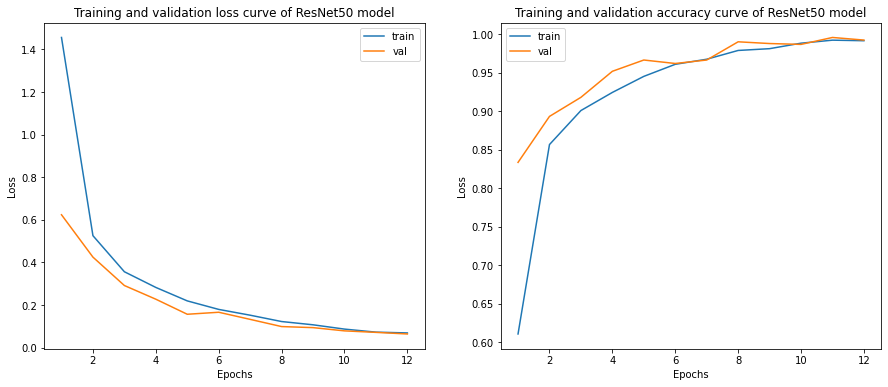

In [31]:
plot_loss_accuracy(model.history, 'ResNet50', EPOCHS)

## Evaluate the model performance on the test dataset

In [32]:
model.evaluate(test_ds)

28/28 [==============================] - 5s 174ms/step - loss: 0.0662 - accuracy: 0.9932


[0.06618749350309372, 0.993228018283844]

### Plot confusion matrix 

In [25]:
def display_confusion_matrix(cmat, score, precision, recall):
  """
  This function plots the confusion matrix on the test data

  Args:
    cmat: normalized confusion matrix
    score: f1-score of the model on the test data
    precision: precision of the model on the test data
    recall: recall of the model on the test data

  Returns:
    None
  """
  plt.figure(figsize = (15, 15))
  ax = plt.gca()

  ax.matshow(cmat, cmap = 'Reds')
  ax.set_xticks(range(len(CLASS_NAMES)))
  ax.set_xticklabels(CLASS_NAMES, fontdict = {'fontsize': 7})
  plt.setp(ax.get_xticklabels(), rotation = 45, ha = "left", rotation_mode = "anchor")

  ax.set_yticks(range(len(CLASS_NAMES)))
  ax.set_yticklabels(CLASS_NAMES, fontdict = {'fontsize': 7})
  plt.setp(ax.get_yticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")

  titlestring = ""
  if score is not None:
    titlestring += 'f1 = {:.3f} '.format(score)
  if precision is not None:
    titlestring += '\nprecision = {:.3f} '.format(precision)
  if recall is not None:
    titlestring += '\nrecall = {:.3f} '.format(recall)
  if len(titlestring) > 0:
    ax.text(30, 1, titlestring, 
            fontdict = {'fontsize': 18, 'horizontalalignment':'right', 
                        'verticalalignment':'top', 'color':'#804040'})
  plt.show()

### Obtain true and predicted labels

In [26]:
def true_pred_labels(model, dataset):
  """
  This function computes true and predicted labels 

  Args:
    model: tensorflow model
    dataset: tensorflow dataset

  Returns:
    correct_labels, predicted_labels
  """
  y_pred = []  # store predicted labels
  y_true = []  # store true labels

  # iterate over the dataset
  for image_batch, label_batch in dataset:
    # append true labels
    y_true.append(label_batch)
    # compute predictions
    preds = model.predict(image_batch)
    # append predicted labels
    y_pred.append(np.argmax(preds, axis = - 1))

  # convert the true and predicted labels into tensors
  correct_labels = tf.concat([item for item in y_true], axis = 0)
  predicted_labels = tf.concat([item for item in y_pred], axis = 0)

  return correct_labels, predicted_labels

In [27]:
def compute_score(y_true, y_pred):
  """
  This function computes confusion matrix, f1_score, precision and recall

  Args:
    y_true: True labels
    y_pred: Predicted labels

  Returns:
    cmat: confusion matrix
    score: f1_score
    precision: precision score
    recall: recall score
  """
  
  labels = range(len(CLASS_NAMES))
  
  # compute confusion matrix
  cmat = confusion_matrix(y_true, y_pred, labels = labels)

  cmat = (cmat.T / cmat.sum(axis = 1)).T # normalize

  # compute f1_score 
  score = f1_score(y_true, y_pred, labels = labels, average = 'macro')

  # compute precision
  precision = precision_score(y_true, y_pred, labels = labels, average = 'macro')

  # compute recall
  recall = recall_score(y_true, y_pred, labels = labels, average = 'macro')

  return cmat, score, precision, recall

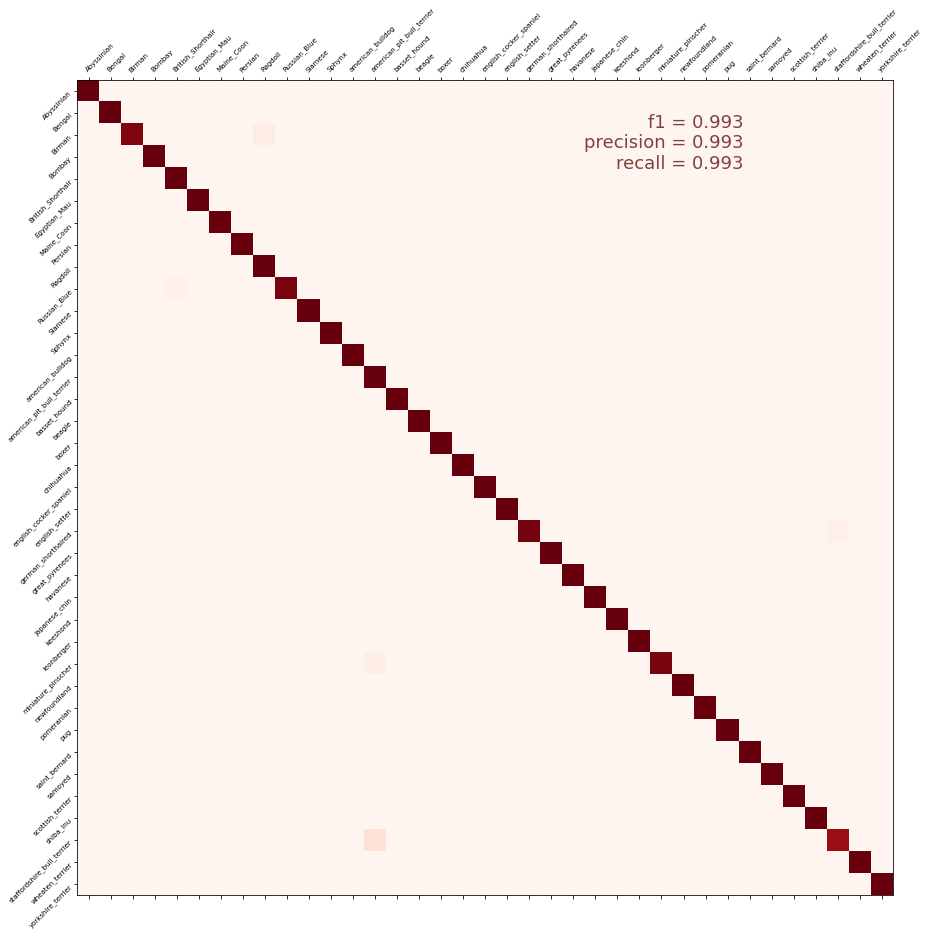

In [33]:
# get true and predicted labels
y_true, y_pred = true_pred_labels(model, test_ds)
# get confusion matrix, f1_score, precision and recall score
cmat, score, precision, recall = compute_score(y_true, y_pred)

# display the results
display_confusion_matrix(cmat, score, precision, recall)

### Display few model predictions

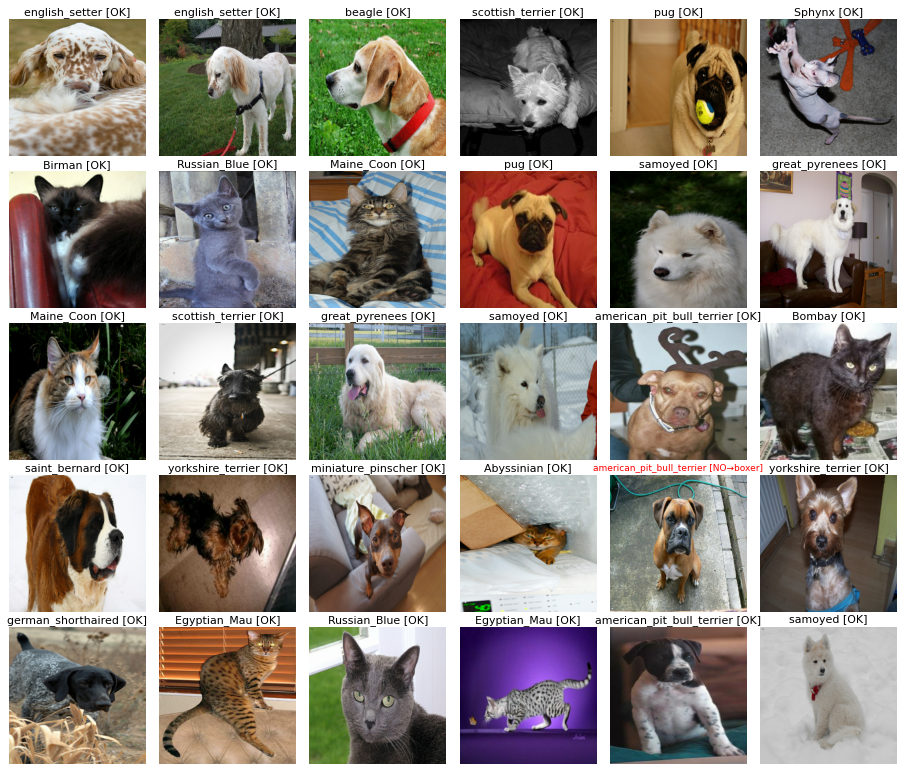

In [34]:
# get image label batch
testing_batch = test_ds.unbatch().batch(BATCH_SIZE)
batch = iter(testing_batch)
images, labels = next(batch)

# compute predictions
probabilities = model.predict(images)
predictions = np.argmax(probabilities, axis = -1)

# display results
display_batch_of_images((images, labels), predictions)